In [1]:
import numpy as np
from matplotlib import pyplot as plt

from collections import OrderedDict
from itertools import chain
from sklearn.utils import shuffle

from rdkit import Chem

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


## Data Loading and Visualization

There are 100 molecules in total. 

This is the chemical structure of the 60th molecule: 

CCOC(C)=O


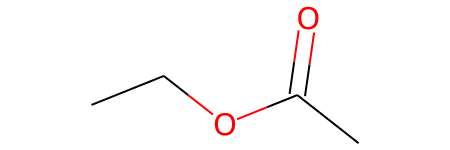

In [2]:
# Load the data
train_data = np.genfromtxt('small_smiles.csv', comments='@', dtype='U')
n_chars = len(train_data)
print("There are " + str(len(train_data)) +" molecules in total. \n" )

# Pick a random molecule from the dataset to visualize
random_molecule = np.random.randint(0, len(train_data)-1)

# Note that this will only work if you installed the rdkit package!
print("This is the chemical structure of the " + str(random_molecule+1) +"th molecule: \n" )
print(str(train_data[random_molecule]))
Chem.MolFromSmiles(train_data[random_molecule])

## Mapping the Characters and Integers

In [3]:
# Get the unique characters from the dataset
unique_chars = sorted(list(OrderedDict.fromkeys(chain.from_iterable(train_data))))

# create mapping of characters to integers and the reverse
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))
int_to_char = dict((i, c) for i, c in enumerate(unique_chars))

# add stop letter to dictionary
char_to_int.update({"|" : len(char_to_int)})
int_to_char.update({len(int_to_char) : "|"})

# how many unique characters do we have?
mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)
#print ("Size of the character to integer dictionary is: ", mapping_size)
#print ("Size of the integer to character dictionary is: ", reverse_mapping_size)

# get longest sequence
embed = max([len(seq) for seq in train_data])
#print ("The longest sequence has " + str(embed) + " characters.")

## One Hot Encoding

In [4]:
# Define the length of the sequence of learning 
seq_length = 1

# Initialize both input/output data matrix as the stop letter "|"
dataX = np.full((len(train_data), embed-seq_length+1), char_to_int["|"])
dataY = np.full((len(train_data), embed-seq_length+1), char_to_int["|"])

# Consider the next character in a molecule as the output of the current character
for i, smile in enumerate(train_data):
    for j, char in enumerate(smile):
        dataX[i, j] = char_to_int[char]
        if j > 0:
            dataY[i, j-1] = char_to_int[char]
    print("The "+str(i+1)+"th molecule "+ str(smile) +" is encoded as "+str(dataX[i,:]))

# Keras utility for one-hot encoding of the characters
X = np_utils.to_categorical(dataX)
Y = np_utils.to_categorical(dataY)

# X and Y array should be (number of training samples, length of longest sequences (with end characters), length of dictionary)
X, Y = shuffle(X, Y)

The 1th molecule CCC=O is encoded as [5 5 5 4 7 8 8 8 8 8 8 8]
The 2th molecule CN=CO is encoded as [5 6 4 5 7 8 8 8 8 8 8 8]
The 3th molecule O=CCO is encoded as [7 4 5 5 7 8 8 8 8 8 8 8]
The 4th molecule CC1CC1 is encoded as [5 5 3 5 5 3 8 8 8 8 8 8]
The 5th molecule CC(C)C=O is encoded as [5 5 1 5 2 5 4 7 8 8 8 8]
The 6th molecule CC(O)C=O is encoded as [5 5 1 7 2 5 4 7 8 8 8 8]
The 7th molecule CN(C)C=O is encoded as [5 6 1 5 2 5 4 7 8 8 8 8]
The 8th molecule CC(=O)CO is encoded as [5 5 1 4 7 2 5 7 8 8 8 8]
The 9th molecule CCC(C)=O is encoded as [5 5 5 1 5 2 4 7 8 8 8 8]
The 10th molecule CCC(=N)O is encoded as [5 5 5 1 4 6 2 7 8 8 8 8]
The 11th molecule CN=C(C)O is encoded as [5 6 4 5 1 5 2 7 8 8 8 8]
The 12th molecule CNC(=N)O is encoded as [5 6 5 1 4 6 2 7 8 8 8 8]
The 13th molecule COC(C)=O is encoded as [5 7 5 1 5 2 4 7 8 8 8 8]
The 14th molecule COC(=N)O is encoded as [5 7 5 1 4 6 2 7 8 8 8 8]
The 15th molecule N=C(O)CO is encoded as [6 4 5 1 7 2 5 7 8 8 8 8]
The 16th molecu

## LSTM Model

In [5]:
# Create the model (simple 2 layer LSTM)
model = Sequential()
model.add(LSTM(256, input_shape=(None, X.shape[2]), return_sequences = True))
model.add(Dropout(0.25))
# model.add(LSTM(512, return_sequences = True))
# model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))
model.add(Dense(Y.shape[-1], activation='softmax'))
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         272384    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense (Dense)                (None, None, 9)           2313      
Total params: 800,009
Trainable params: 800,009
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam')

# Fit the model
history = model.fit(X, Y, epochs = 500, batch_size = 256, verbose=1)

Train on 100 samples
Epoch 1/500
100/100 [==============================] - 6s 60ms/sample - loss: 2.1993
Epoch 2/500
100/100 [==============================] - 0s 1ms/sample - loss: 2.1543
Epoch 3/500
100/100 [==============================] - 0s 1ms/sample - loss: 2.1043
Epoch 4/500
100/100 [==============================] - 0s 1ms/sample - loss: 2.0373
Epoch 5/500
100/100 [==============================] - 0s 1ms/sample - loss: 1.9404
Epoch 6/500
100/100 [==============================] - 0s 1ms/sample - loss: 1.8114
Epoch 7/500
100/100 [==============================] - 0s 1ms/sample - loss: 1.7080
Epoch 8/500
100/100 [==============================] - 0s 1ms/sample - loss: 1.7504
Epoch 9/500
100/100 [==============================] - 0s 1ms/sample - loss: 1.7878
Epoch 10/500
100/100 [==============================] - 0s 1ms/sample - loss: 1.7359
Epoch 11/500
100/100 [==============================] - 0s 1ms/sample - loss: 1.6753
Epoch 12/500
100/100 [==============================

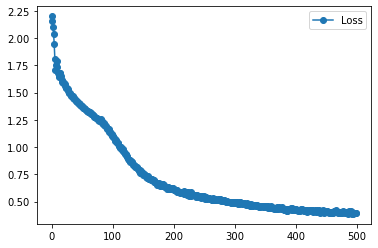

In [7]:
plt.plot(history.history["loss"], '-o', label="Loss")
plt.legend()
plt.show()

### Compare the predictions with the training data

In [8]:
# Calculate predictions
predictions = model.predict(X, verbose=0)

# Compare to correct result
train_res = np.argmax(Y,axis=2)-np.argmax(predictions,axis=2)

# Count correct and incorrect predictions
no_false = np.count_nonzero(train_res)
no_true = len(Y)*embed-no_false
print("Average success rate on training set: %s %%" %str(np.round(100*no_true/(embed*len(Y)),2)))

Average success rate on training set: 84.5 %


In [9]:
# Compare the model predictions and the "ground truth" training set side by sidie

max_display = min(10, len(train_data))   # can be a pre-defined value, say 10 molecules at most

for i in range(max_display):
    v = model.predict(X[i:i+1]) 
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])
    
    # Note that here we use the argmax and do not sample using the model output
    idxs2 = np.argmax(Y[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])
    if true != pred:
        print (true, pred)

C(O)C(=N)O|| C(=)C(=N)O||
C1(C)CC1|||| C((C)CC1||||
C1(C)CC1O||| C((C)CC1||||
OC(C)=O||||| CCCC)=O|||||
C(=O)C(=N)N| C(=O)C(CN)N|
#CCC(C)C|||| CCC#(C)C||||
OCC#CC#N|||| CCC(CC#N||||
#CCC(=N)O||| CCC#(CN)O|||
=C(N)C(=O)O| =C(O)C(=O)O|
C(=O)C(C)C|| C(=O)C(C)=||


## Molecule Generation

N=
N=C
N=CC
N=CCN
N=CCNC
N=CCNCC
N=CCNCCC
N=CCNCCCC
N=CCNCCCCC
N=CCNCCCCCC
N=CCNCCCCCCC


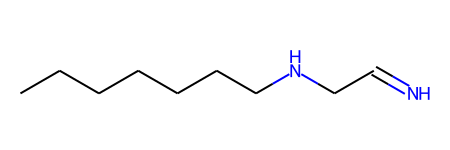

In [27]:
# Define a given starting seed character of the molecule
seed = 'N'

# Set the size to be the same as the training set
size = Y.shape[-1]

# Initialize array of probabilities and character
pred = []
preds = []
next_char = []

molecule = seed
molecule_n = np.zeros((1,1,size))
molecule_n[0, 0, char_to_int[seed]] = 1
 
# Continue as long as we do not add '|'

while next_char !='|' and len(molecule) < embed:    
    # use the model to predict the probability of the next character
    pred = model.predict(np.expand_dims(molecule_n[:,-1,:], axis = 1)).flatten()
    preds.append(pred) 
    
    # generate the next character with the highest probability
#    index = np.argmax(pred).astype(int)
    # generate the next character "randomly" based on the predicted probability         
    index = np.random.choice(np.arange(0,len(char_to_int)), size=None, replace=True, p=pred)
    next_char = int_to_char[index]      
    molecule += next_char
    print(molecule)
    
    molecule_new = np.zeros((1, 1, size))
    molecule_new[0, 0, char_to_int[next_char]] = 1
    molecule_n = np.append(molecule_n, molecule_new, axis=1)     
    
preds = np.array(preds)
Chem.MolFromSmiles(molecule)

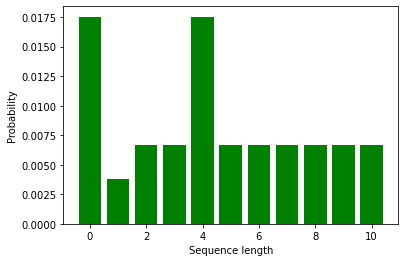

In [28]:
# As the sequence gets longer, the probability of '|' changes.
plt.bar(range(len(preds[:,-1])), preds[:,-1], color='g')
plt.xlabel('Sequence length')
plt.ylabel('Probability')
plt.show()

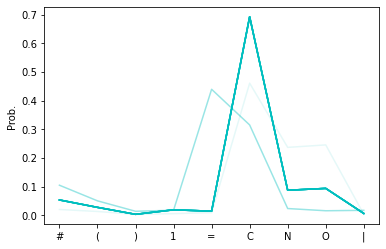

In [32]:
# Plot probability distributions over the sequence
fig, ax = plt.subplots()

for i in range(len(preds)):
    ax.plot(preds[i,:], 'c', alpha=min(i * 0.1, 1))       

ax.set_xticks(np.arange(0,len(char_to_int)))    
ax.set_xticklabels(list(char_to_int.keys()))
plt.ylabel('Probability')
plt.show()